DATASET ../Datasets/IMDB-Dataset-MideindTranslate-processed-nefnir.csv
Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', MultinomialNB())])
              precision    recall  f1-score   support

           0     0.8429    0.8623    0.8525      8208
           1     0.8605    0.8409    0.8506      8292

    accuracy                         0.8516     16500
   macro avg     0.8517    0.8516    0.8516     16500
weighted avg     0.8518    0.8516    0.8516     16500

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LinearSVC())])
              precision    recall  f1-score   support

           0     0.8864    0.8737    0.8800      8208
           1     0.8767    0.8892    0.8829      8292

    accuracy                         0.8815     16500
   macro avg     0.8815    0.8814    0.8814     16500
weighted avg     0.8815    0.8815    0.8814     16500

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LogisticRegression())])
              precision    recall  f1-score   support

   

<Figure size 3200x1600 with 0 Axes>

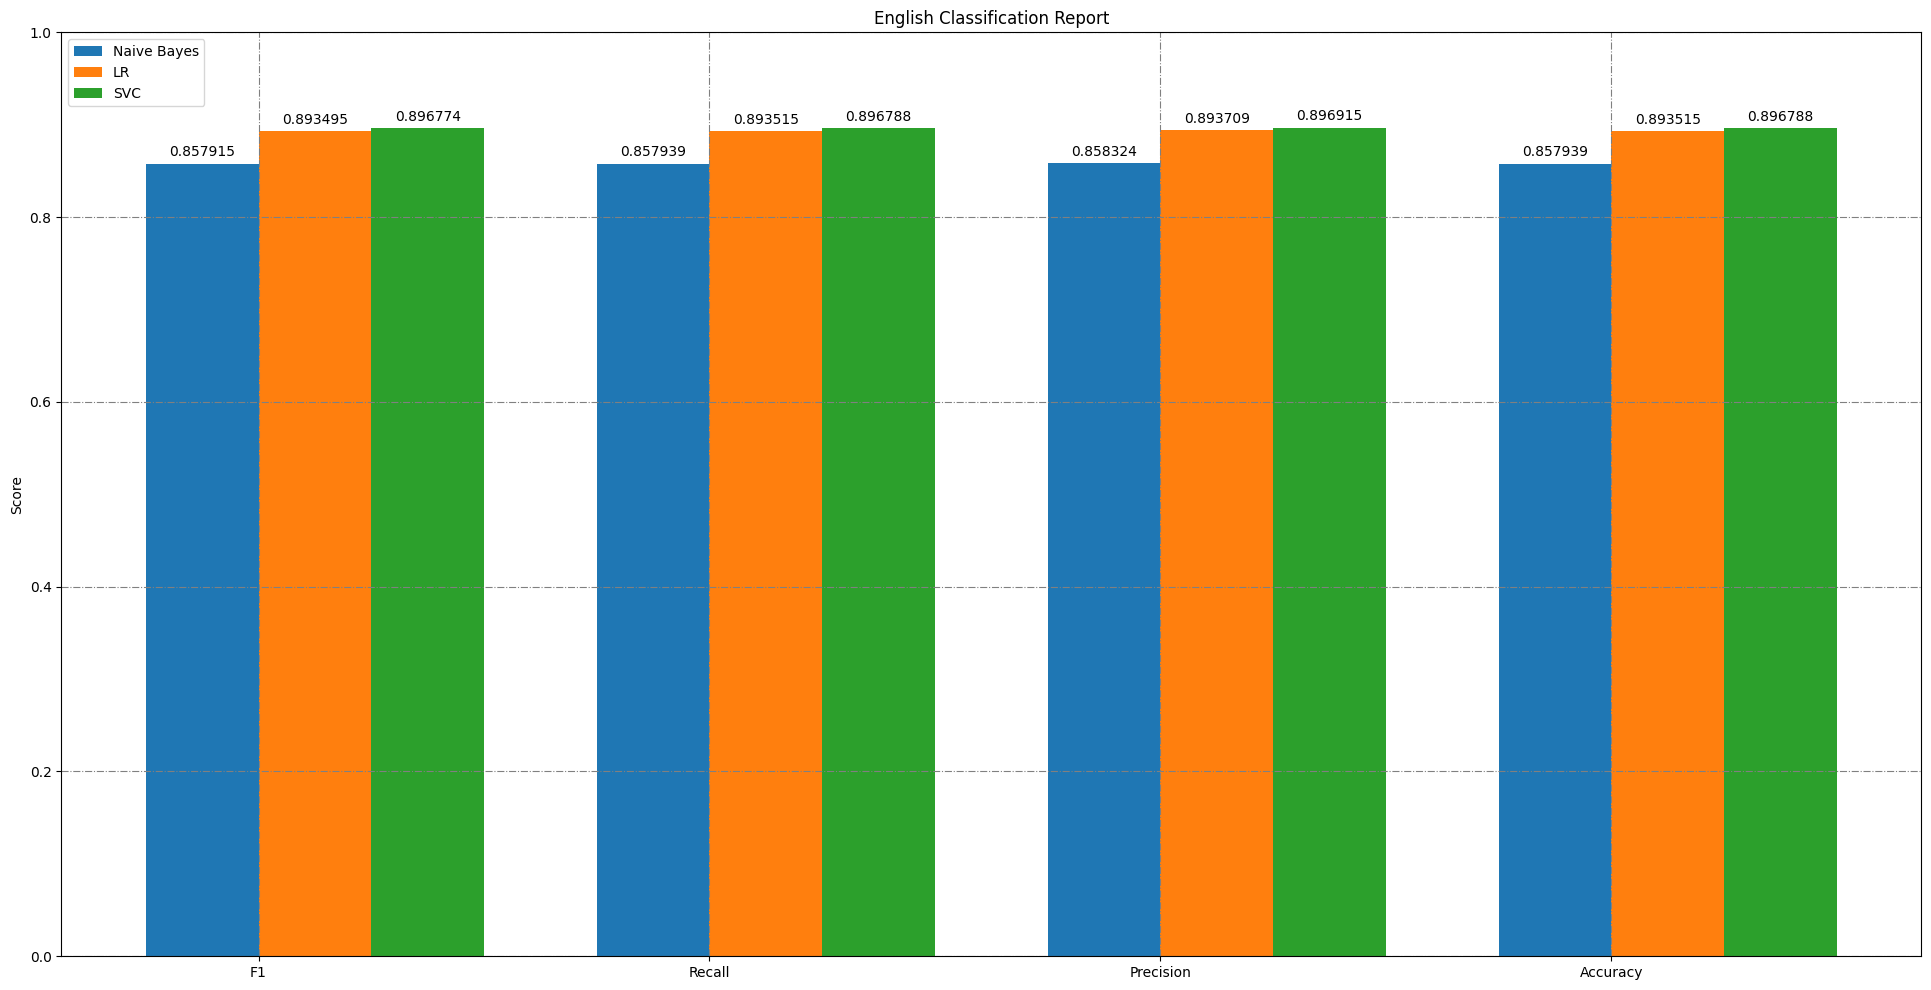

<Figure size 3200x1600 with 0 Axes>

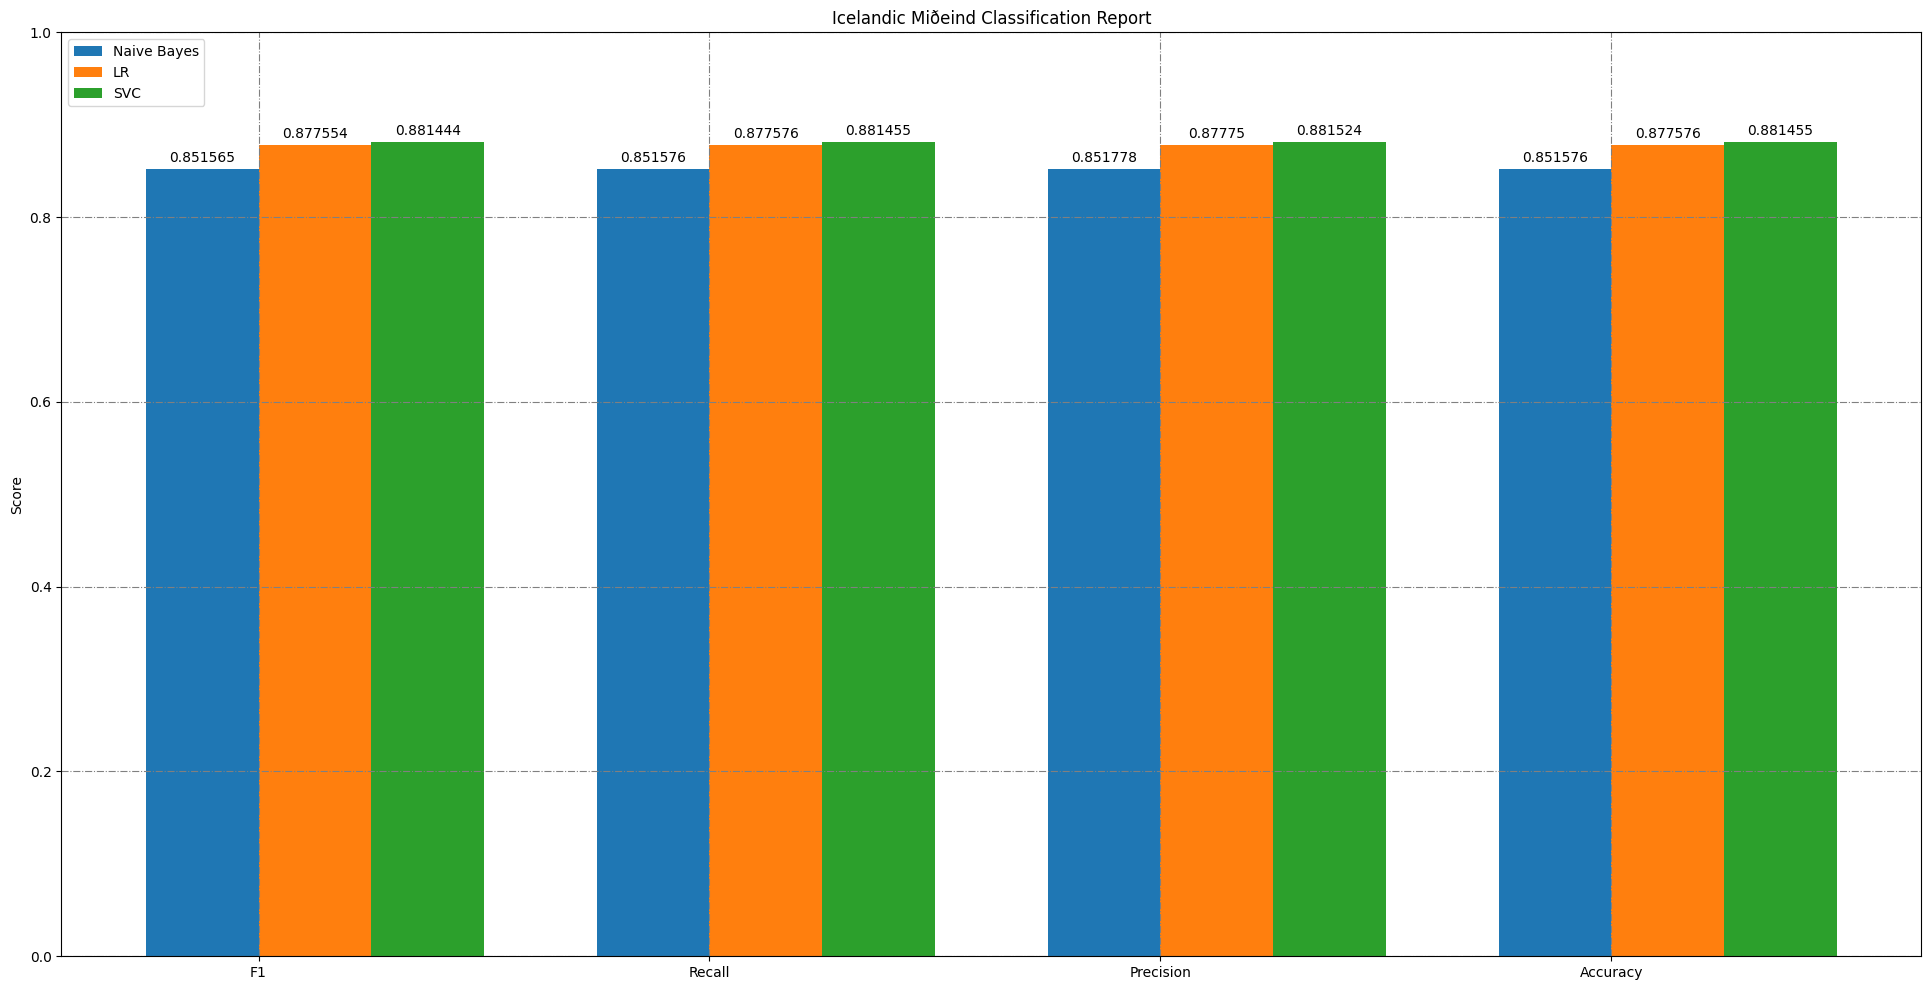

<Figure size 3200x1600 with 0 Axes>

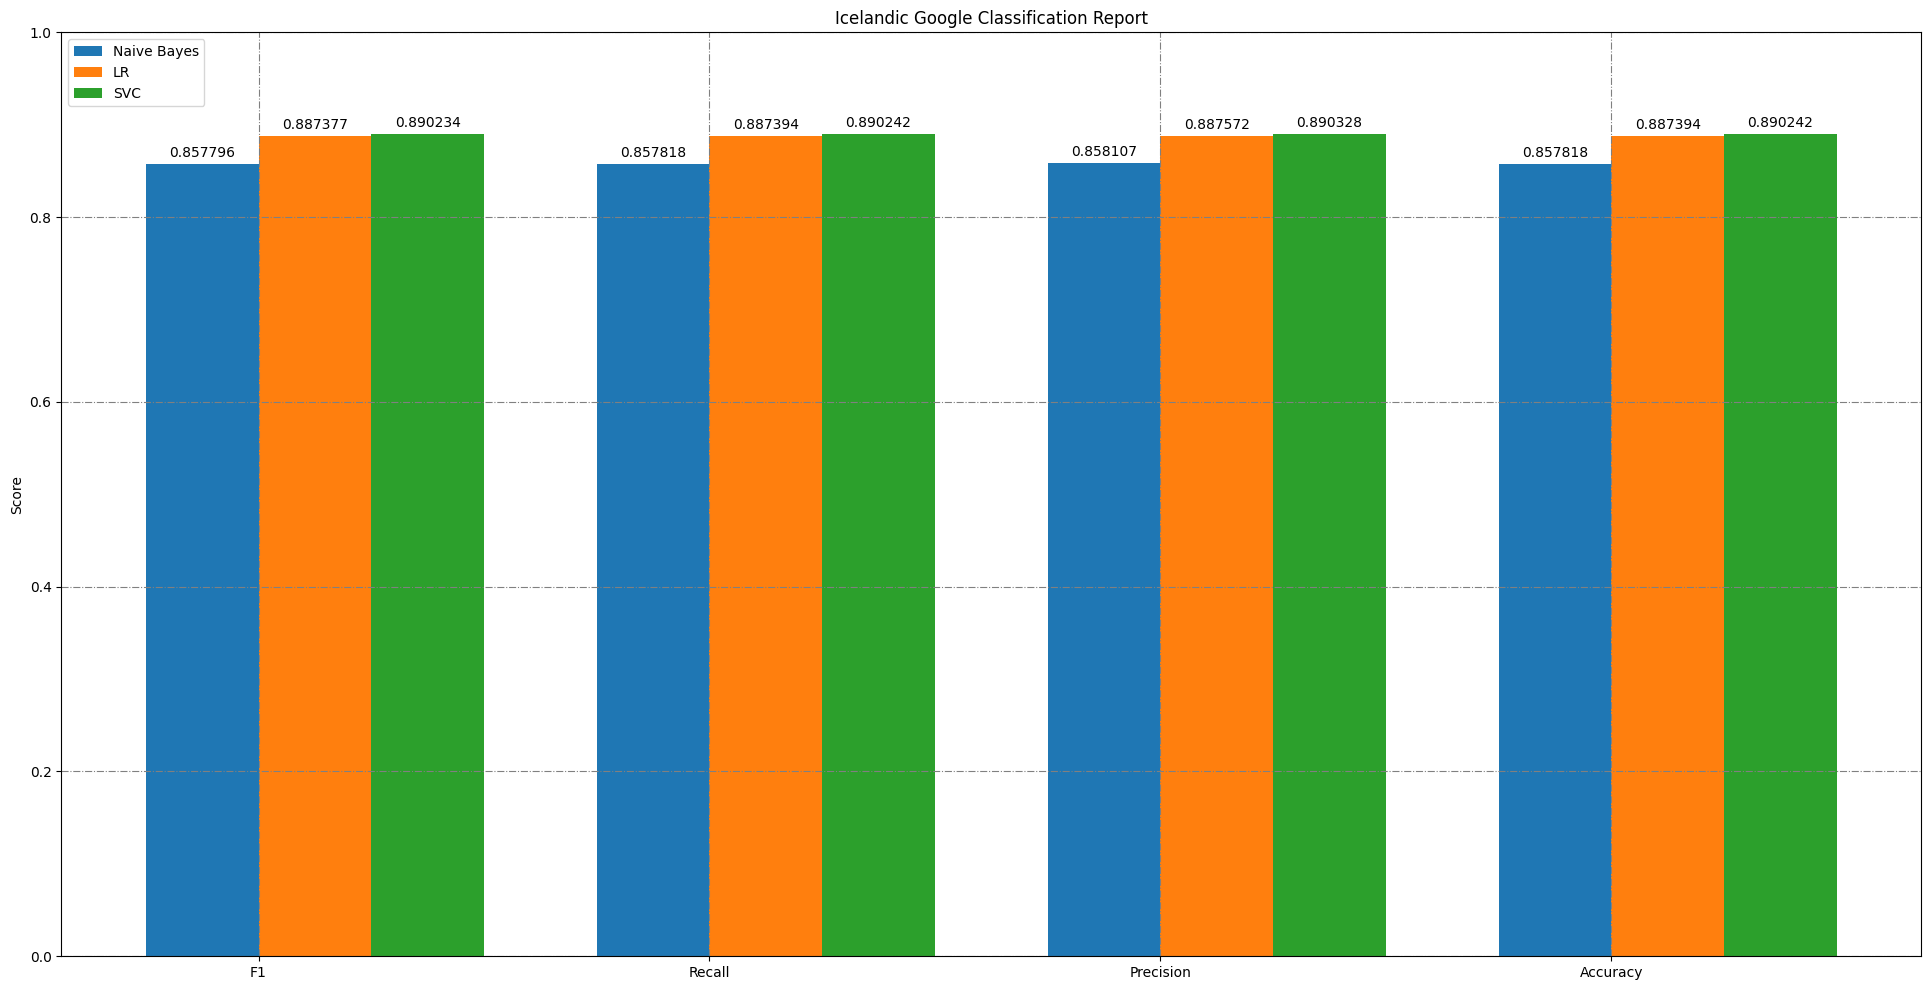

In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

ICELANDIC_GOOGLE_CSV = "../Datasets/IMDB-Dataset-GoogleTranslate-processed-nefnir.csv"
ICELANDIC_MIDEIND_CSV = "../Datasets/IMDB-Dataset-MideindTranslate-processed-nefnir.csv"
ENGLISH_CSV = "../Datasets/IMDB-Dataset-Processed.csv"


def clear_df(data):
    if "Unnamed: 0" in data.columns:
        data.drop(["Unnamed: 0"], axis=1, inplace=True)
    if "id" in data.columns:
        data.drop(["id"], axis=1, inplace=True)

    def convert(sentiment):
        return 1 if sentiment == "positive" else 0

    data["sentiment"] = data.sentiment.apply(convert)
    review, sentiment = data["review"].values.astype("U"), data["sentiment"].to_numpy()
    return review, sentiment


def classify(path, train_path=None, eval_path=None):
    print("DATASET %s" % path)
    train_df, eval_df = None, None

    if train_path is not None and eval_path is not None:
        train_df = pd.read_csv(train_path)
        eval_df = pd.read_csv(eval_path)
        x_train, y_train = clear_df(train_df)
        x_test, y_test = clear_df(eval_df)
    else:
        data = pd.read_csv(path)
        review, sentiment = clear_df(data)
        x_train, x_test, y_train, y_test = train_test_split(
            review, sentiment, test_size=0.33, random_state=42
        )

    nb_pipeline = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", MultinomialNB()),
        ]
    )
    svc_pipeline = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", LinearSVC()),
        ]
    )
    lr_pipeline = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", LogisticRegression()),
        ]
    )

    nb_pipeline.fit(x_train, y_train)
    svc_pipeline.fit(x_train, y_train)
    lr_pipeline.fit(x_train, y_train)

    predict_nb = nb_pipeline.predict(x_test)
    predict_svc = svc_pipeline.predict(x_test)
    predict_lr = lr_pipeline.predict(x_test)

    f1_nb = f1_score(y_test, predict_nb, average="weighted")
    recall_nb = recall_score(y_test, predict_nb, average="weighted")
    prec_nb = precision_score(y_test, predict_nb, average="weighted")
    accuracy_nb = accuracy_score(y_test, predict_nb)

    f1_svc = f1_score(y_test, predict_svc, average="weighted")
    recall_svc = recall_score(y_test, predict_svc, average="weighted")
    prec_svc = precision_score(y_test, predict_svc, average="weighted")
    accuracy_svc = accuracy_score(y_test, predict_svc)

    f1_lr = f1_score(y_test, predict_lr, average="weighted")
    recall_lr = recall_score(y_test, predict_lr, average="weighted")
    prec_lr = precision_score(y_test, predict_lr, average="weighted")
    accuracy_lr = accuracy_score(y_test, predict_lr)

    print(nb_pipeline)
    print(classification_report(y_test, predict_nb, digits=4))

    print(svc_pipeline)
    print(classification_report(y_test, predict_svc, digits=4))

    print(lr_pipeline)
    print(classification_report(y_test, predict_lr, digits=4))

    return (
        (
            {
                "Naive Bayes": (f1_nb, recall_nb, prec_nb, accuracy_nb),
                "LR": (f1_lr, recall_lr, prec_lr, accuracy_lr),
                "SVC": (f1_svc, recall_svc, prec_svc, accuracy_svc),
            },
            ["F1", "Recall", "Precision", "Accuracy"],
        ),
        nb_pipeline,
        svc_pipeline,
        lr_pipeline,
    )


def plot_f1(f1s, title):
    labels, values = f1s
    plt.figure(figsize=(32, 16))
    fig, ax = plt.subplots(figsize=(24, 12))
    plt.grid(color="grey", linestyle="-.")
    x = np.arange(4)
    width = 0.25
    multiplier = 0
    # Add annotation to bars
    for attr, m in labels.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, m, width, label=attr)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.set_xticks(x + width / 2, ("F1", "Recall", "Precision", "Accuracy"))
    plt.legend(loc="upper left")
    plt.savefig("%s.png" % title.replace(" ", "_"))
    ax.set_ylim(0, 1)

    plt.show()


data2, nb_mideind, svc_mideind, lr_mideind = classify(ICELANDIC_MIDEIND_CSV)
data3, nb_google, svc_google, lr_google = classify(ICELANDIC_GOOGLE_CSV)
data1, nb_english, svc_english, lr_english = classify(ENGLISH_CSV)


plot_f1(data1, "English Classification Report")
plot_f1(data2, "Icelandic Miðeind Classification Report")
plot_f1(data3, "Icelandic Google Classification Report")

C:\Users\Notandi\AppData\Local\Temp\ipykernel_11532\1619360562.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(121)


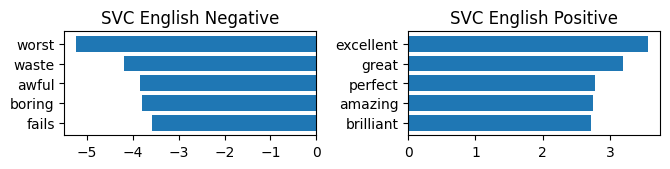

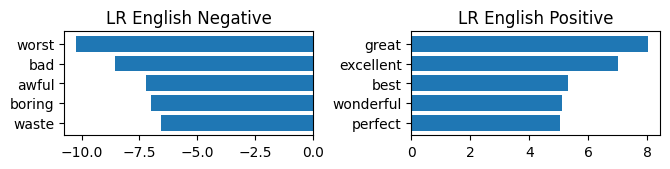

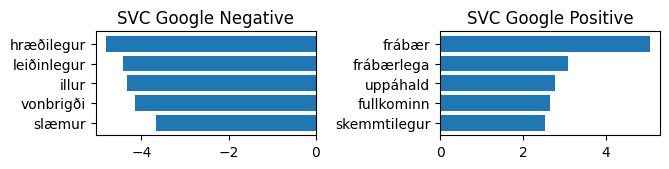

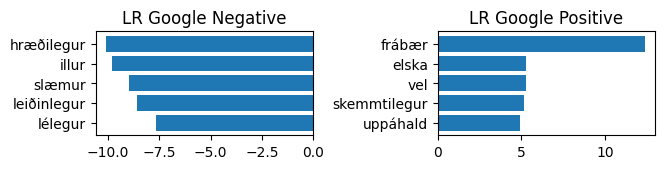

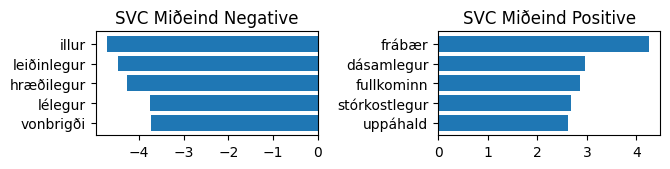

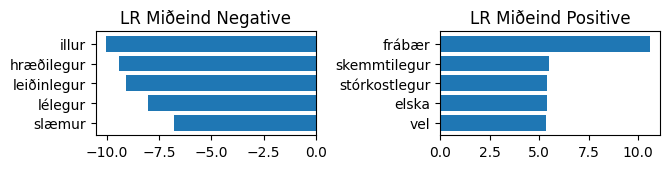

In [11]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [
            (el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])
        ]
        sorted_coeff = sorted(word_importances, key=lambda x: x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key=lambda x: x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {"tops": tops, "bottom": bottom}
    return classes


def show_most_informative_features(vectorizer, clf, n=20):
    print(clf)
    feature_names = vectorizer.get_feature_names_out()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[: -(n + 1) : -1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.3f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))



def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    top_pairs = [(a, b) for a, b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a, b) for a, b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    fig, ax = plt.subplots()
    fig.set_figwidth(6.8)
    fig.set_figheight(1.8)

    ax = plt.subplot(121)
    y_pos = np.arange(len(bottom_words))
    p1 = plt.barh(y_pos, bottom_scores, align="center")
    plt.yticks(y_pos, bottom_words)
    negative_title = name % "Negative"
    plt.title(negative_title)
    plt.tight_layout()

    ax = plt.subplot(122)
    y_pos = np.arange(len(top_words))
    p2 = plt.barh(y_pos, top_scores, align="center")
    plt.yticks(y_pos, top_words)
    positive_title = name % "Positive"
    plt.title(positive_title)
    plt.tight_layout()
    figname = name % "Important"
    plt.savefig("%s.png" % figname.replace(" ", "_"))
    plt.show()


def show(model, name):
    importance = get_most_important_features(model[0], model[1], 5)
    top_scores = [a[0] for a in importance[0]["tops"]]
    top_words = [a[1] for a in importance[0]["tops"]]
    bottom_scores = [a[0] for a in importance[0]["bottom"]]
    bottom_words = [a[1] for a in importance[0]["bottom"]]

    plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name)


show(svc_english, "SVC English %s")
show(lr_english, "LR English %s")
show(svc_google, "SVC Google %s")
show(lr_google, "LR Google %s")
show(svc_mideind, "SVC Miðeind %s")
show(lr_mideind, "LR Miðeind %s")